# N:2 MENT — sample-based solver

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import proplot as pplt
import psdist as ps
import psdist.plot as psv
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.utils import unravel

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

Settings:

In [3]:
dist_name = "gaussian_mixture"
ndim = 4
xmax = 3.5
seed = 12345
rng = np.random.default_rng(seed)

Define the source distribution.

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed, noise=0.5)
X_true = dist.sample(1_000_000)
X_true[:, (0, 1)] = ment.dist.get_dist("galaxy").sample(X_true.shape[0])
X_true[:, (2, 3)] = ment.dist.get_dist("galaxy").sample(X_true.shape[0])
X_true[:, (2, 3)] = np.flip(X_true[:, (2, 3)], axis=1)

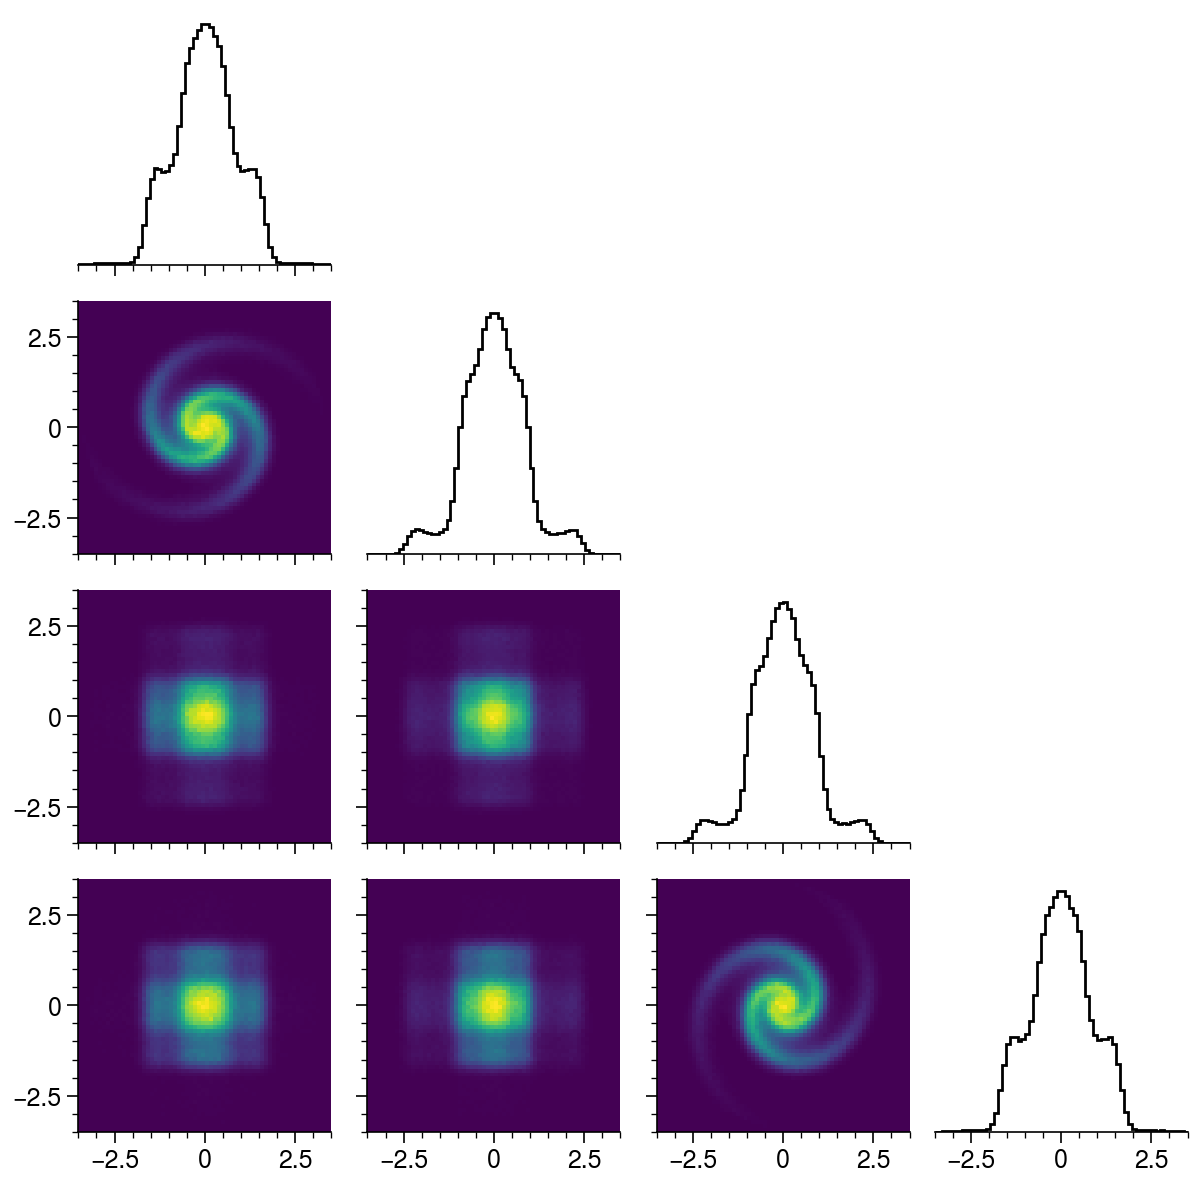

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(X_true, limits=limits, bins=64, mask=False)
plt.show()

Generate data.

In [6]:
# Settings
nmeas = ndim * (ndim - 1) // 2
nbins = 64
kde = False
kde_bandwidth = 1.0

# Create transforms (permutation matrices)
rng = np.random.default_rng(seed)
axis_meas = (0, 2)
n_meas = ndim * (ndim - 1) // 2

transfer_matrices = []
for i in range(ndim):
    for j in range(i):
        matrices = []
        for k, l in zip(axis_meas, (j, i)):
            matrix = np.identity(ndim)
            matrix[k, k] = matrix[l, l] = 0.0
            matrix[k, l] = matrix[l, k] = 1.0
            matrices.append(matrix)
        transfer_matrices.append(np.linalg.multi_dot(matrices[::-1]))

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create diagnostics
axis_proj = axis_meas
bin_edges = len(axis_proj) * [np.linspace(-xmax, xmax, nbins + 1)]

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.Histogram2D(
        axis=(0, 2), edges=bin_edges, kde=kde, kde_bandwidth=kde_bandwidth
    )
    diagnostics.append([diagnostic])

# Generate data
projections = ment.sim.forward(X_true, transforms, diagnostics)

## Model

In [11]:
sampler = "mcmc"
nsamp = 1_000_000
burnin = 500
chains = 1000
c = 2.4 / np.sqrt(ndim)

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=chains,
        proposal_cov=(0.25 * np.eye(ndim)),
        start=np.random.multivariate_normal(np.zeros(ndim), 0.25 * np.eye(ndim), size=chains),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

prior = ment.GaussianPrior(ndim=ndim, scale=5.0)

integration_limits = [limits[i] for i in range(ndim) if i not in axis_proj]
integration_limits = [[integration_limits]] * len(transforms)

model = ment.MENT(
    ndim=ndim,
    projections=projections,
    transforms=transforms,
    diagnostics=diagnostics,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    integration_limits=integration_limits,
    integration_size=(10**4),
    integration_batches=1,
    store_integration_points=True,
    mode="integrate",
    verbose=True,
)

## Training

In [12]:
plot_nsamp = 1_000_000

In [13]:
def plot_model(model):
    figs = []

    # Plot reconstructed vs. true distribution.
    X_pred = model.sample(plot_nsamp)

    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        X_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Plot simulated vs. measured projections.
    projections_true = model.projections
    projections_true = unravel(projections_true)
    projections_pred = ment.sim.forward(X_pred, transforms, diagnostics)
    projections_pred = unravel(projections_pred)

    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, norm="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.7,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for values_true, values_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_image(values_true.T, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_image(values_pred.T, ax=ax, colors=contour_colors[1], **plot_kws)    
    figs.append(fig)

    return figs

non numeric history values being saved


100%|███████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:01<00:00, 1382.10it/s]


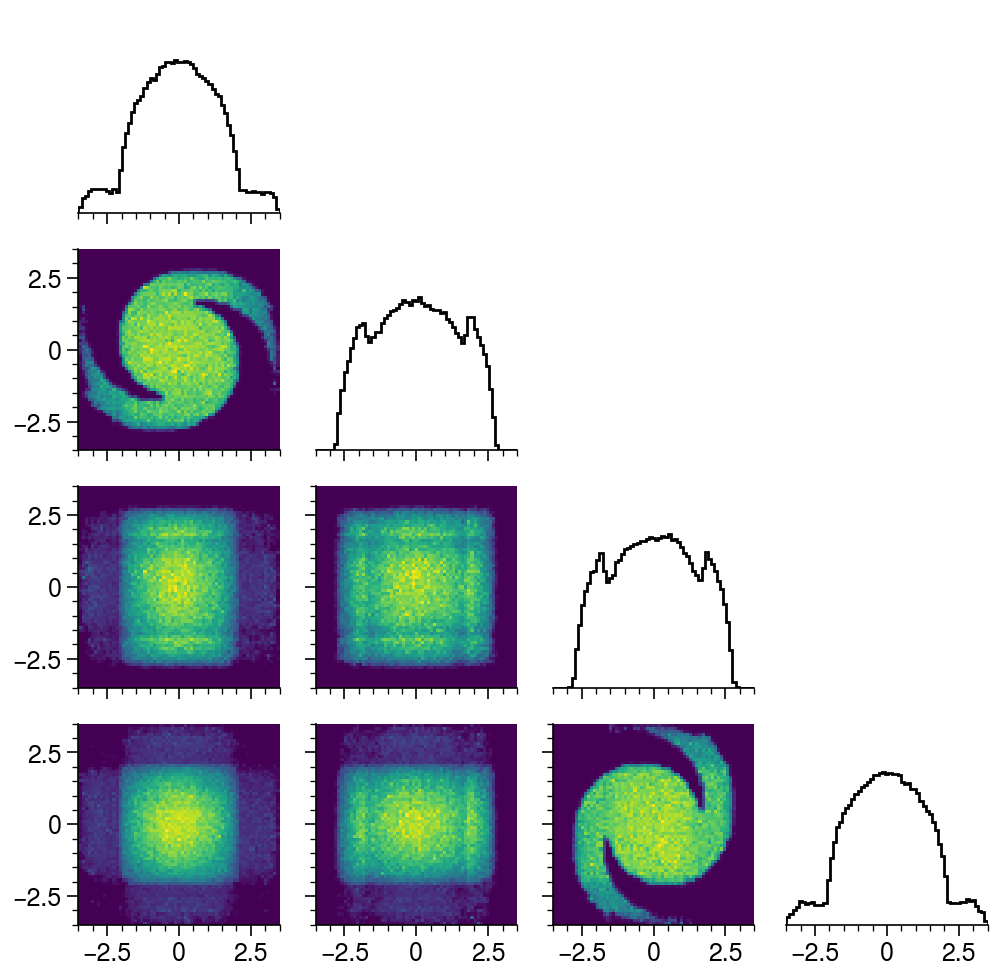

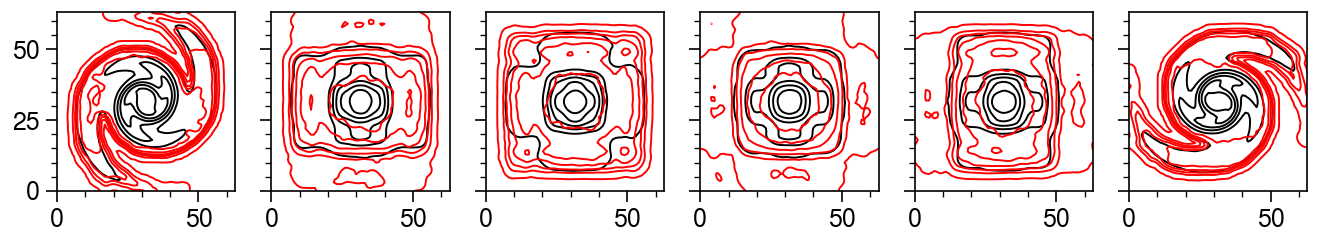

epoch = 1
index=0
index=1
index=2
index=3
index=4
index=5


100%|███████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:01<00:00, 1447.47it/s]


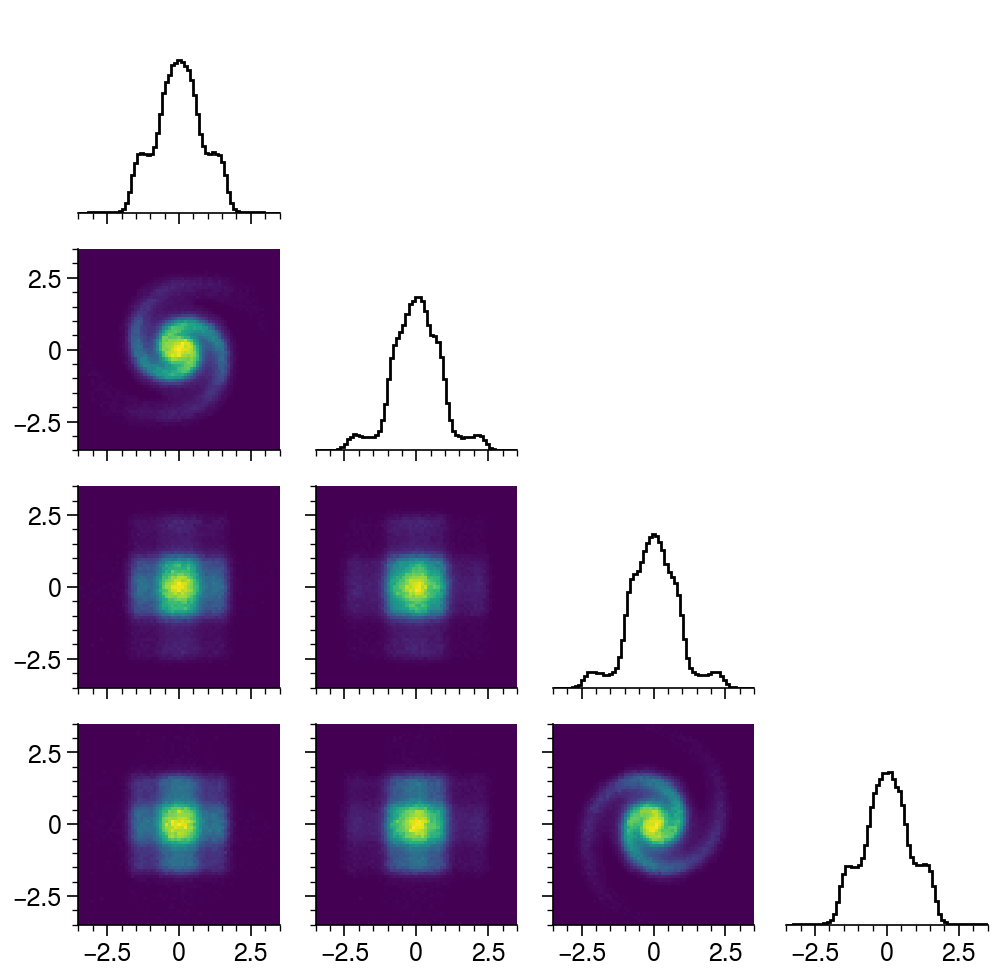

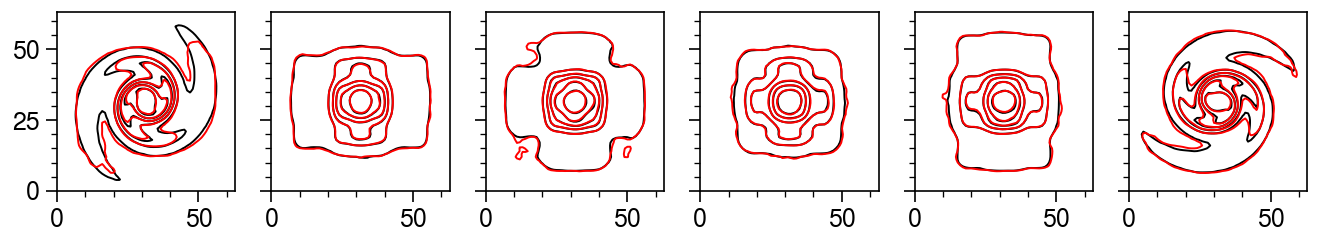

epoch = 2
index=0
index=1
index=2
index=3
index=4
index=5


100%|███████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:01<00:00, 1484.14it/s]


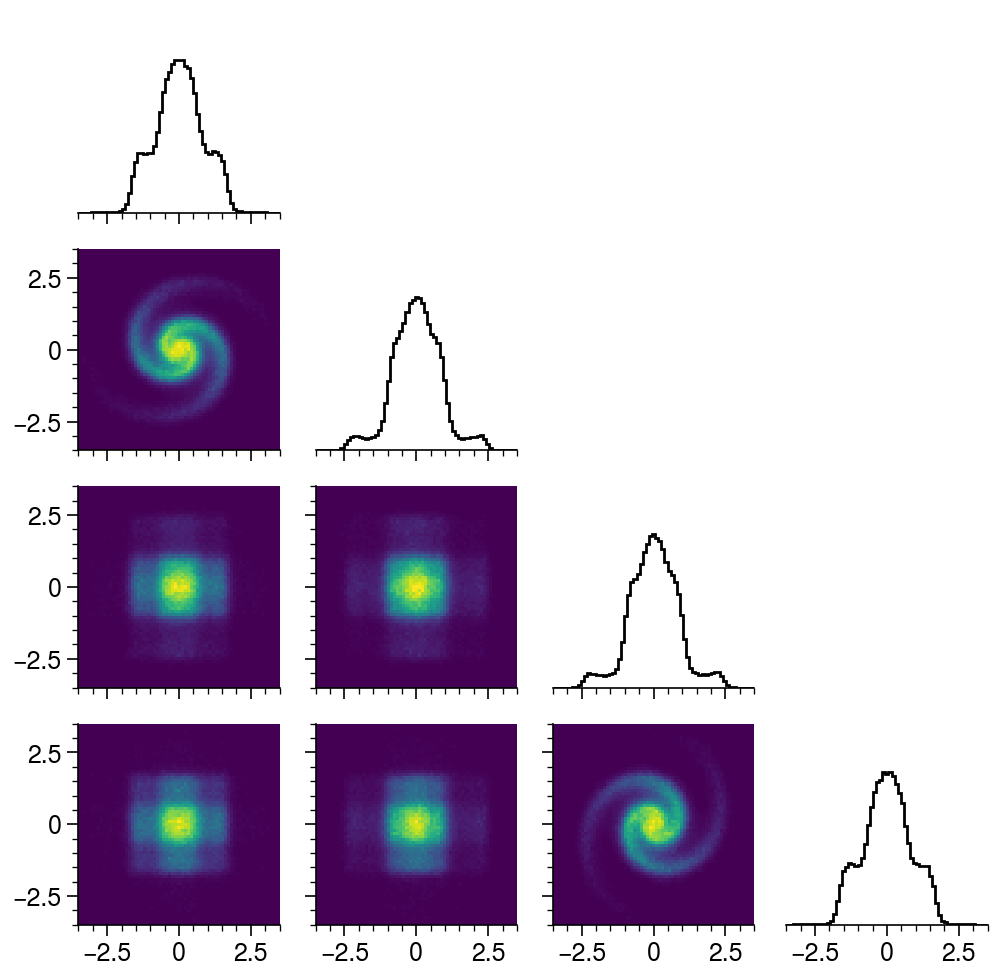

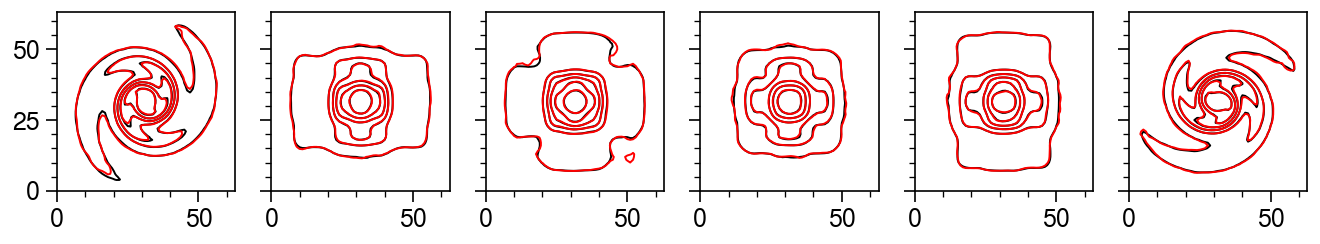

epoch = 3
index=0
index=1
index=2
index=3
index=4
index=5


100%|███████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 1512.04it/s]


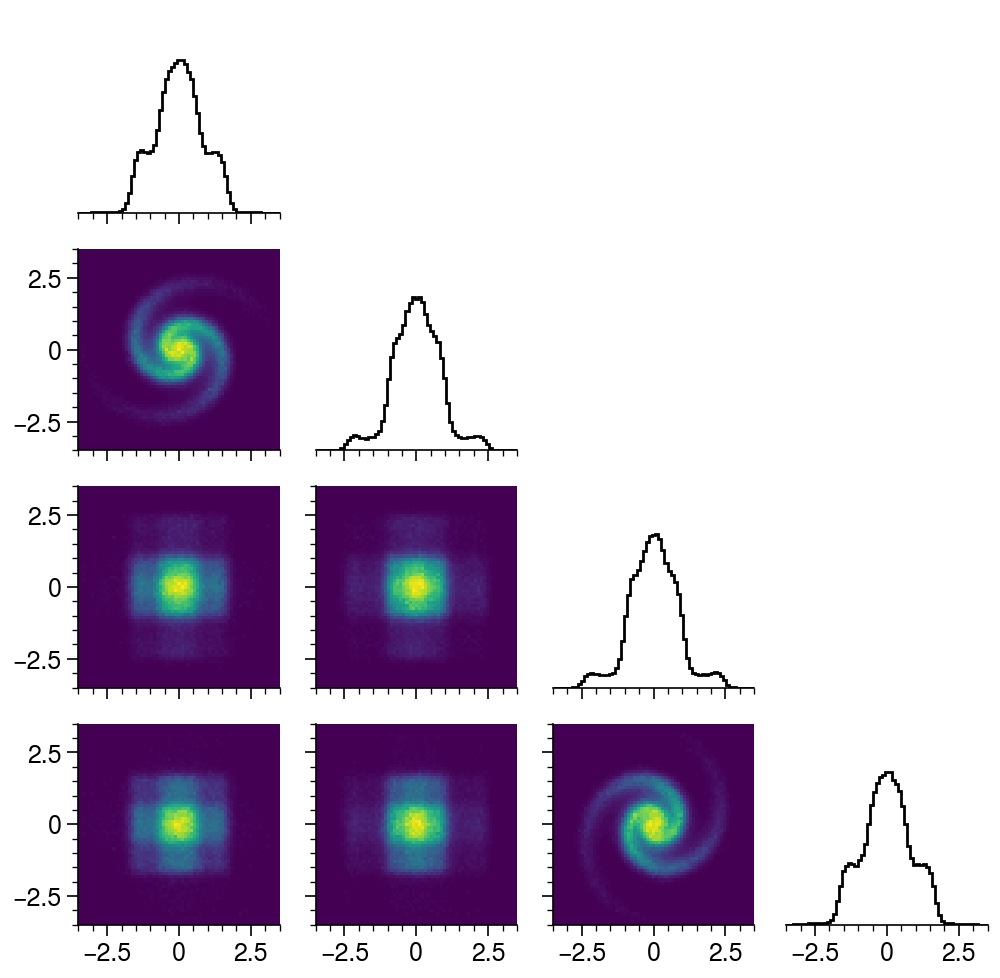

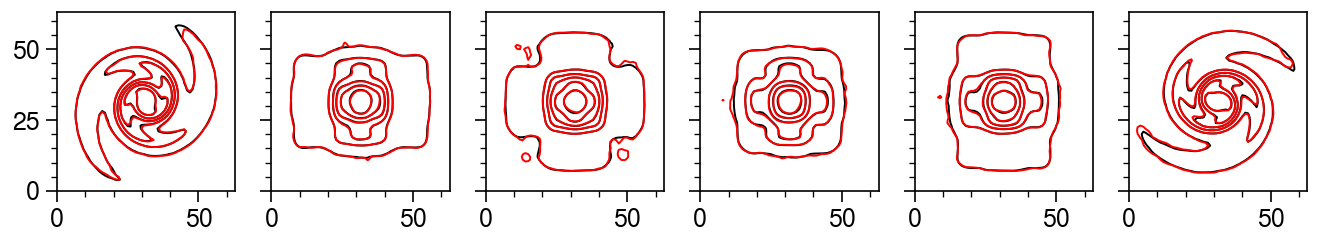

In [14]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)
trainer.train(epochs=3, learning_rate=0.80)

## Final check

In [ ]:
X = model.sample(100_000)